In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from tqdm import trange
import pandas as pd

In [2]:
sys.path.append('/home/raffaele/Documents/ml-project/src/')

In [3]:
from torch_utility import *

## Import Dataset

In [4]:
data = np.genfromtxt('/home/raffaele/Documents/ml-project/cup/ML-CUP20-TR.csv', delimiter=',', dtype=np.float32)
X = data[:, 1:-2]
y = data[:, -2:]

In [5]:
print(X.shape)
print(y.shape)

(1524, 10)
(1524, 2)


### Split train set and Validation Set

In [6]:
Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size=0.10, random_state=42)

In [7]:
print(Xtrain.shape)
print(ytrain.shape)
print(Xval.shape)
print(yval.shape)

(1371, 10)
(1371, 2)
(153, 10)
(153, 2)


In [8]:
class Net(nn.Module):

    def __init__(self, num_units1, num_units2, activation):
        super(Net, self).__init__()
        self.activation = activation
        self.input_layer = nn.Linear(10,num_units1)
        self.hidden1 = nn.Linear(num_units1, num_units2)
        self.output = nn.Linear(num_units2,2)

    def forward(self, x):
        x = self.activation(self.input_layer(x))
        x = self.activation(self.hidden1(x))
        x = self.output(x)
        return x

In [9]:
class MEE(torch.nn.Module):

    def __init__(self):
        super(MEE, self).__init__()

    def forward(self, y_true, y_pred):
#         return torch.mean(torch.linalg.norm(y_pred - y_true))
#         return torch.mean(torch.cdist(y_true, y_pred, p=2))
        return torch.div(torch.sum(torch.pairwise_distance(y_true, y_pred)), len(y_true))
#         return torch.div(torch.linalg.norm(y_pred - y_true, ord=None), len(y_true))
#         return torch.div(torch.linalg.norm(y_pred - y_true), len(y_true))

In [10]:
from sklearn.metrics import euclidean_distances

def mean_euclidean_error(y_true, y_pred):
    assert y_true.shape == y_pred.shape
#     return np.mean(np.linalg.norm(y_pred - y_true))
#     return np.divide(np.linalg.norm(y - y_real), len(y_real))
#     return np.mean(euclidean_distances(y_true, y_pred))
    return np.mean(np.linalg.norm(y_true - y_pred, axis=1)) #utilizzare questa loss la prossima grid

In [11]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.0)

In [25]:
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping
import time

begin = time.time()

total = []
for i in range(0,10):
    test_net = Net(100, 50, torch.sigmoid)
    nett = NeuralNetRegressor(test_net, max_epochs=1000,
                              lr=0.006,
                              batch_size=64,
                              optimizer=optim.SGD,
                              optimizer__momentum=0.8,
                              optimizer__weight_decay=0.0001,
                              optimizer__nesterov = True,
                              criterion=MEE,
    #                           callbacks=[EarlyStopping(patience=100)]
                             )
    # Training
    nett.fit(Xtrain, ytrain)

    prova = nett.predict(Xval)
    ris = mean_euclidean_error(prova, yval)
    total.append(ris)

end = time.time()
print(str(begin-end) + ' Seconds')

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       54.5463       49.1832  0.0638
      2       44.0975       34.2943  0.0620
      3       27.2937       19.9657  0.0581
      4       18.5028       16.6272  0.0566
      5       16.4470       15.7114  0.0565
      6       15.7029       15.0246  0.0670
      7       14.8917       14.0064  0.0583
      8       13.6785       12.5132  0.0566
      9       12.0654       10.7709  0.0550
     10       10.4162        9.3318  0.0595
     11        9.3120        8.6090  0.0568
     12        8.8648        8.4289  0.0899
     13        8.7291        8.3813  0.0597
     14        8.6699        8.3585  0.0582
     15        8.6329        8.3368  0.0584
     16        8.6022        8.3134  0.0627
     17        8.5745        8.2895  0.0575
     18        8.5489        8.2662  0.0940
     19        8.5247        8.2437  0.0554
     20        8.5015        8.2211  0.0814
     21        8.4788        8.1

    136        3.1136        3.1994  0.0655
    137        3.1071        3.2065  0.0541
    138        3.1076        3.1968  0.0464
    139        3.1013        3.2005  0.0565
    140        3.1008        3.1876  0.0483
    141        3.0935        3.1936  0.0721
    142        3.0942        3.1858  0.0460
    143        3.0881        3.1884  0.0591
    144        3.0877        3.1779  0.0471
    145        3.0807        3.1825  0.0486
    146        3.0815        3.1746  0.0468
    147        3.0749        3.1775  0.0543
    148        3.0749        3.1742  0.0581
    149        3.0710        3.1717  0.0539
    150        3.0678        3.1689  0.0486
    151        3.0647        3.1665  0.0578
    152        3.0618        3.1639  0.0524
    153        3.0589        3.1614  0.0476
    154        3.0560        3.1588  0.0477
    155        3.0532        3.1564  0.0875
    156        3.0503        3.1539  0.0512
    157        3.0475        3.1515  0.0469
    158        3.0447        3.1

    282        2.8114        2.9752  0.0601
    283        2.8050        2.9796  0.0477
    284        2.8094        2.9750  0.0667
    285        2.8023        2.9784  0.0660
    286        2.8076        2.9744  0.0495
    287        2.8003        2.9768  0.0480
    288        2.8060        2.9739  0.0469
    289        2.7979        2.9751  0.0453
    290        2.8040        2.9735  0.0477
    291        2.7958        2.9734  0.0476
    292        2.8013        2.9731  0.0479
    293        2.7938        2.9721  0.0465
    294        2.7987        2.9726  0.0504
    295        2.7917        2.9711  0.0491
    296        2.7963        2.9722  0.0918
    297        2.7897        2.9704  0.0477
    298        2.7942        2.9717  0.0488
    299        2.7877        2.9698  0.0692
    300        2.7921        2.9712  0.0577
    301        2.7857        2.9692  0.0553
    302        2.7901        2.9707  0.0520
    303        2.7837        2.9686  0.0583
    304        2.7882        2.9

    445        2.6718        2.9392  0.0559
    446        2.6682        2.9470  0.0509
    447        2.6770        2.9330  0.0471
    448        2.6672        2.9373  0.0541
    449        2.6676        2.9343  0.0464
    450        2.6662        2.9450  0.0478
    451        2.6697        2.9422  0.0901
    452        2.6663        2.9309  0.0537
    453        2.6632        2.9470  0.0479
    454        2.6688        2.9269  0.0470
    455        2.6620        2.9279  0.0503
    456        2.6615        2.9481  0.0455
    457        2.6638        2.9398  0.0476
    458        2.6612        2.9273  0.0448
    459        2.6615        2.9248  0.0791
    460        2.6597        2.9408  0.0485
    461        2.6664        2.9385  0.0467
    462        2.6587        2.9281  0.0460
    463        2.6589        2.9287  0.0464
    464        2.6580        2.9400  0.0485
    465        2.6608        2.9479  0.0501
    466        2.6589        2.9222  0.0476
    467        2.6537        2.9

    614        2.5816        2.9100  0.0528
    615        2.5813        2.9034  0.0478
    616        2.5834        2.8950  0.0498
    617        2.5813        2.9016  0.0469
    618        2.5794        2.9087  0.0497
    619        2.5795        2.9084  0.1151
    620        2.5789        2.8973  0.0480
    621        2.5791        2.9154  0.0527
    622        2.5786        2.8963  0.0464
    623        2.5787        2.9125  0.0471
    624        2.5802        2.9012  0.0466
    625        2.5775        2.9019  0.0542
    626        2.5764        2.8964  0.0452
    627        2.5765        2.9257  0.0468
    628        2.5786        2.8936  0.0478
    629        2.5768        2.8978  0.0476
    630        2.5740        2.9059  0.0475
    631        2.5749        2.9122  0.0465
    632        2.5765        2.8922  0.0673
    633        2.5760        2.8986  0.0481
    634        2.5714        2.9017  0.0485
    635        2.5736        2.8992  0.0578
    636        2.5719        2.9

    787        2.5273        2.8829  0.0520
    788        2.5229        2.8698  0.0538
    789        2.5194        2.8797  0.0506
    790        2.5252        2.8868  0.0469
    791        2.5199        2.8734  0.1641
    792        2.5193        2.8975  0.0564
    793        2.5200        2.9093  0.0471
    794        2.5249        2.8822  0.0468
    795        2.5205        2.8710  0.0466
    796        2.5154        2.8992  0.0471
    797        2.5199        2.8763  0.0473
    798        2.5175        2.8738  0.0517
    799        2.5199        2.8876  0.0451
    800        2.5204        2.9274  0.0769
    801        2.5297        2.8754  0.0456
    802        2.5162        2.8757  0.0473
    803        2.5116        2.8875  0.0451
    804        2.5168        2.8757  0.0462
    805        2.5156        2.8872  0.0478
    806        2.5155        2.8721  0.0508
    807        2.5140        2.8788  0.0456
    808        2.5167        2.9256  0.0476
    809        2.5274        2.8

    965        2.4653        2.8762  0.0535
    966        2.4664        2.8994  0.0497
    967        2.4729        2.8645  0.0546
    968        2.4643        2.8971  0.0476
    969        2.4722        2.8747  0.0450
    970        2.4676        2.8962  0.0460
    971        2.4729        2.8639  0.0447
    972        2.4634        2.8881  0.0494
    973        2.4618        2.8670  0.0469
    974        2.4610        2.8992  0.0447
    975        2.4721        2.8640  0.0522
    976        2.4619        2.8777  0.1341
    977        2.4604        2.8772  0.0475
    978        2.4653        2.9022  0.0473
    979        2.4705        2.8668  0.0464
    980        2.4649        2.8807  0.0545
    981        2.4636        2.9006  0.0489
    982        2.4745        2.8651  0.0506
    983        2.4597        2.8804  0.0658
    984        2.4584        2.8950  0.0558
    985        2.4671        2.8638  0.0712
    986        2.4609        2.8819  0.0581
    987        2.4584        2.8

    104        3.2803        3.3168  0.0588
    105        3.2747        3.3121  0.0514
    106        3.2693        3.3084  0.0484
    107        3.2640        3.3073  0.0472
    108        3.2591        3.3089  0.0494
    109        3.2548        3.3093  0.0540
    110        3.2499        3.3107  0.0659
    111        3.2464        3.3056  0.0518
    112        3.2420        3.3043  0.0587
    113        3.2384        3.2991  0.0534
    114        3.2337        3.2971  0.0452
    115        3.2300        3.2935  0.0496
    116        3.2258        3.2908  0.0787
    117        3.2220        3.2878  0.0475
    118        3.2181        3.2850  0.0465
    119        3.2144        3.2821  0.0475
    120        3.2107        3.2793  0.0502
    121        3.2070        3.2765  0.0503
    122        3.2035        3.2738  0.0520
    123        3.1999        3.2711  0.0477
    124        3.1964        3.2684  0.0527
    125        3.1930        3.2657  0.0497
    126        3.1895        3.2

    237        2.8921        3.0503  0.0587
    238        2.8899        3.0493  0.0562
    239        2.8878        3.0483  0.0517
    240        2.8858        3.0472  0.0517
    241        2.8839        3.0461  0.0568
    242        2.8820        3.0450  0.0537
    243        2.8801        3.0439  0.0535
    244        2.8782        3.0428  0.0486
    245        2.8763        3.0417  0.0685
    246        2.8744        3.0406  0.0487
    247        2.8725        3.0394  0.0451
    248        2.8706        3.0383  0.0480
    249        2.8688        3.0372  0.0493
    250        2.8669        3.0360  0.0483
    251        2.8651        3.0349  0.0559
    252        2.8633        3.0338  0.0655
    253        2.8615        3.0327  0.0721
    254        2.8597        3.0316  0.0541
    255        2.8579        3.0306  0.0466
    256        2.8561        3.0295  0.0550
    257        2.8543        3.0285  0.1628
    258        2.8526        3.0275  0.1703
    259        2.8509        3.0

    391        2.6972        2.9584  0.0513
    392        2.6985        2.9780  0.0608
    393        2.7046        2.9539  0.0487
    394        2.6952        2.9651  0.0462
    395        2.6961        2.9680  0.0531
    396        2.6974        2.9563  0.0460
    397        2.6930        2.9538  0.0466
    398        2.6941        2.9697  0.0879
    399        2.6994        2.9664  0.0536
    400        2.7019        2.9661  0.0473
    401        2.6933        2.9573  0.0545
    402        2.6908        2.9553  0.0458
    403        2.6895        2.9635  0.0492
    404        2.6900        2.9499  0.0486
    405        2.6886        2.9678  0.0463
    406        2.6903        2.9468  0.0447
    407        2.6860        2.9523  0.0497
    408        2.6865        2.9687  0.0594
    409        2.6886        2.9466  0.0464
    410        2.6844        2.9501  0.0470
    411        2.6846        2.9671  0.0563
    412        2.6865        2.9559  0.0475
    413        2.6888        2.9

    559        2.6007        2.9336  0.0538
    560        2.6026        2.9149  0.0464
    561        2.5999        2.9214  0.0516
    562        2.5989        2.9151  0.0530
    563        2.6017        2.9186  0.0611
    564        2.6018        2.9257  0.0464
    565        2.6032        2.9154  0.0472
    566        2.5991        2.9332  0.0475
    567        2.6017        2.9145  0.0645
    568        2.5965        2.9206  0.0639
    569        2.5970        2.9124  0.0556
    570        2.5990        2.9292  0.1122
    571        2.5952        2.9198  0.0500
    572        2.5976        2.9188  0.0460
    573        2.5932        2.9108  0.0492
    574        2.5958        2.9155  0.0462
    575        2.5987        2.9138  0.0480
    576        2.5980        2.9128  0.0553
    577        2.5973        2.9269  0.0664
    578        2.5936        2.9141  0.0470
    579        2.5928        2.9239  0.0517
    580        2.5935        2.9224  0.0609
    581        2.5916        2.9

    729        2.5334        2.8911  0.0870
    730        2.5318        2.9029  0.0476
    731        2.5312        2.8908  0.0459
    732        2.5314        2.8958  0.0674
    733        2.5346        2.8908  0.0551
    734        2.5347        2.9056  0.0936
    735        2.5320        2.8889  0.0797
    736        2.5300        2.8944  0.0463
    737        2.5281        2.8994  0.0482
    738        2.5302        2.8972  0.0570
    739        2.5307        2.8909  0.0583
    740        2.5298        2.8905  0.0463
    741        2.5281        2.9070  0.0599
    742        2.5310        2.8890  0.0468
    743        2.5277        2.8944  0.0463
    744        2.5260        2.8882  0.0585
    745        2.5279        2.8958  0.1507
    746        2.5261        2.8898  0.1730
    747        2.5268        2.8933  0.0757
    748        2.5238        2.8975  0.0548
    749        2.5267        2.8972  0.0533
    750        2.5270        2.8944  0.0461
    751        2.5264        2.8

    901        2.4761        2.8798  0.0519
    902        2.4758        2.8821  0.0484
    903        2.4730        2.8775  0.0477
    904        2.4794        2.8936  0.0497
    905        2.4742        2.8788  0.0472
    906        2.4776        2.9215  0.0447
    907        2.4873        2.8850  0.0463
    908        2.4767        2.8973  0.0544
    909        2.4757        2.8793  0.0455
    910        2.4745        2.8804  0.0460
    911        2.4716        2.8813  0.1638
    912        2.4746        2.8843  0.0469
    913        2.4739        2.8833  0.0980
    914        2.4706        2.8833  0.0461
    915        2.4720        2.8905  0.0451
    916        2.4747        2.8789  0.0480
    917        2.4708        2.8843  0.0476
    918        2.4697        2.8811  0.0453
    919        2.4707        2.8854  0.0812
    920        2.4686        2.8836  0.0507
    921        2.4703        2.8941  0.0485
    922        2.4712        2.8776  0.0456
    923        2.4713        2.8

     55        4.1585        4.1075  0.0481
     56        4.0876        4.0498  0.0478
     57        4.0295        4.0011  0.0712
     58        3.9821        3.9588  0.0454
     59        3.9415        3.9224  0.0445
     60        3.9060        3.8909  0.0458
     61        3.8737        3.8616  0.0465
     62        3.8434        3.8336  0.0461
     63        3.8147        3.8072  0.0485
     64        3.7873        3.7824  0.0468
     65        3.7609        3.7588  0.0517
     66        3.7354        3.7361  0.0481
     67        3.7108        3.7142  0.0454
     68        3.6868        3.6936  0.0478
     69        3.6644        3.6740  0.0501
     70        3.6431        3.6544  0.0458
     71        3.6222        3.6352  0.0574
     72        3.6021        3.6167  0.0445
     73        3.5828        3.5991  0.0457
     74        3.5651        3.5829  0.0970
     75        3.5484        3.5671  0.0497
     76        3.5319        3.5520  0.0472
     77        3.5163        3.5

    190        2.9657        3.0857  0.0511
    191        2.9634        3.0840  0.0474
    192        2.9610        3.0824  0.0448
    193        2.9587        3.0808  0.0708
    194        2.9564        3.0792  0.0520
    195        2.9541        3.0777  0.0556
    196        2.9518        3.0762  0.0472
    197        2.9495        3.0747  0.0450
    198        2.9472        3.0733  0.0432
    199        2.9450        3.0718  0.0644
    200        2.9427        3.0704  0.0472
    201        2.9405        3.0690  0.0568
    202        2.9383        3.0677  0.0458
    203        2.9361        3.0663  0.0551
    204        2.9339        3.0650  0.0454
    205        2.9317        3.0637  0.0471
    206        2.9296        3.0624  0.0469
    207        2.9275        3.0611  0.0456
    208        2.9254        3.0599  0.0573
    209        2.9233        3.0587  0.0468
    210        2.9212        3.0574  0.0478
    211        2.9192        3.0562  0.0636
    212        2.9171        3.0

    336        2.7483        2.9792  0.0521
    337        2.7504        2.9792  0.0476
    338        2.7464        2.9785  0.0449
    339        2.7485        2.9786  0.1184
    340        2.7446        2.9777  0.0469
    341        2.7467        2.9780  0.0507
    342        2.7429        2.9769  0.0527
    343        2.7448        2.9773  0.0530
    344        2.7412        2.9762  0.0540
    345        2.7429        2.9766  0.0468
    346        2.7397        2.9755  0.0455
    347        2.7409        2.9757  0.0489
    348        2.7385        2.9751  0.0459
    349        2.7387        2.9750  0.0966
    350        2.7382        2.9751  0.0470
    351        2.7363        2.9746  0.0470
    352        2.7376        2.9737  0.0489
    353        2.7344        2.9735  0.0473
    354        2.7346        2.9730  0.0559
    355        2.7346        2.9722  0.0453
    356        2.7332        2.9798  0.0450
    357        2.7323        2.9732  0.0470
    358        2.7320        2.9

    497        2.6403        2.9402  0.0478
    498        2.6460        2.9353  0.0482
    499        2.6383        2.9387  0.0483
    500        2.6373        2.9455  0.0522
    501        2.6377        2.9370  0.0444
    502        2.6403        2.9350  0.0898
    503        2.6361        2.9414  0.0489
    504        2.6357        2.9374  0.0449
    505        2.6382        2.9477  0.0462
    506        2.6484        2.9404  0.0480
    507        2.6384        2.9448  0.0489
    508        2.6324        2.9326  0.0913
    509        2.6340        2.9412  0.0534
    510        2.6324        2.9426  0.0809
    511        2.6348        2.9312  0.0456
    512        2.6334        2.9341  0.0575
    513        2.6322        2.9452  0.0489
    514        2.6322        2.9480  0.0460
    515        2.6403        2.9317  0.0557
    516        2.6314        2.9356  0.0482
    517        2.6296        2.9329  0.0450
    518        2.6302        2.9350  0.0550
    519        2.6285        2.9

    665        2.5630        2.9091  0.0487
    666        2.5660        2.9130  0.0481
    667        2.5663        2.9144  0.0462
    668        2.5655        2.9057  0.0486
    669        2.5621        2.9186  0.0637
    670        2.5620        2.9054  0.0499
    671        2.5606        2.9104  0.0535
    672        2.5610        2.9066  0.0480
    673        2.5600        2.9241  0.0461
    674        2.5659        2.9130  0.0499
    675        2.5608        2.9127  0.0462
    676        2.5646        2.9062  0.0451
    677        2.5624        2.9176  0.0470
    678        2.5608        2.9039  0.0449
    679        2.5574        2.9051  0.0470
    680        2.5574        2.9083  0.1648
    681        2.5580        2.9168  0.0450
    682        2.5581        2.9032  0.0477
    683        2.5561        2.9107  0.0794
    684        2.5591        2.9057  0.0467
    685        2.5583        2.9117  0.0477
    686        2.5556        2.9055  0.0492
    687        2.5564        2.9

    835        2.5025        2.8918  0.1336
    836        2.4993        2.8954  0.0632
    837        2.5056        2.9007  0.0457
    838        2.5034        2.8865  0.0459
    839        2.4984        2.9193  0.1068
    840        2.5028        2.8893  0.0521
    841        2.4978        2.8924  0.0470
    842        2.5015        2.8909  0.0494
    843        2.4996        2.8964  0.0461
    844        2.4999        2.9000  0.0500
    845        2.4960        2.9000  0.0852
    846        2.5076        2.8908  0.0484
    847        2.4965        2.8958  0.0506
    848        2.4970        2.9014  0.0494
    849        2.4951        2.8912  0.0476
    850        2.4961        2.9093  0.0567
    851        2.4964        2.8862  0.0466
    852        2.4939        2.8886  0.0453
    853        2.4935        2.8979  0.0469
    854        2.4960        2.8874  0.0529
    855        2.4930        2.8943  0.0524
    856        2.4967        2.8902  0.0484
    857        2.4924        2.8

      4       18.6477       16.6350  0.0535
      5       16.4062       15.6044  0.0506
      6       15.5513       14.7799  0.0482
      7       14.5758       13.5500  0.0472
      8       13.1508       11.8598  0.0492
      9       11.4213       10.1500  0.0479
     10        9.9266        8.9862  0.0840
     11        9.1383        8.5570  0.0469
     12        8.8618        8.4728  0.0485
     13        8.7719        8.4397  0.0476
     14        8.7265        8.4161  0.0461
     15        8.6922        8.3908  0.0494
     16        8.6614        8.3647  0.0472
     17        8.6325        8.3385  0.0465
     18        8.6051        8.3126  0.0491
     19        8.5786        8.2871  0.0573
     20        8.5526        8.2619  0.0454
     21        8.5269        8.2366  0.0475
     22        8.5011        8.2110  0.0468
     23        8.4754        8.1866  0.0529
     24        8.4487        8.1587  0.0506
     25        8.4201        8.1296  0.0502
     26        8.3897        8.0

    138        3.0945        3.1819  0.0586
    139        3.0910        3.1790  0.0502
    140        3.0874        3.1761  0.0473
    141        3.0836        3.1732  0.0459
    142        3.0797        3.1703  0.0482
    143        3.0761        3.1674  0.0510
    144        3.0727        3.1646  0.0464
    145        3.0693        3.1618  0.0468
    146        3.0660        3.1590  0.0488
    147        3.0627        3.1563  0.0922
    148        3.0595        3.1536  0.0469
    149        3.0563        3.1509  0.0547
    150        3.0531        3.1482  0.0539
    151        3.0499        3.1456  0.0475
    152        3.0467        3.1430  0.0461
    153        3.0436        3.1405  0.0475
    154        3.0405        3.1379  0.0463
    155        3.0375        3.1354  0.0463
    156        3.0344        3.1330  0.0479
    157        3.0314        3.1305  0.0460
    158        3.0285        3.1281  0.0479
    159        3.0255        3.1257  0.0479
    160        3.0226        3.1

    271        2.8252        2.9953  0.0497
    272        2.8235        2.9957  0.0705
    273        2.8237        2.9949  0.0468
    274        2.8220        2.9944  0.1694
    275        2.8208        2.9939  0.1747
    276        2.8196        2.9934  0.0890
    277        2.8184        2.9928  0.0470
    278        2.8173        2.9922  0.0461
    279        2.8162        2.9916  0.0460
    280        2.8150        2.9913  0.1505
    281        2.8136        2.9919  0.0464
    282        2.8138        2.9912  0.0468
    283        2.8122        2.9905  0.0471
    284        2.8108        2.9901  0.0506
    285        2.8097        2.9894  0.0479
    286        2.8086        2.9883  0.0477
    287        2.8074        2.9874  0.0457
    288        2.8058        2.9892  0.0451
    289        2.8062        2.9887  0.0513
    290        2.8051        2.9876  0.1149
    291        2.8032        2.9874  0.0486
    292        2.8024        2.9867  0.0467
    293        2.8011        2.9

    431        2.6857        2.9375  0.0540
    432        2.6943        2.9374  0.0446
    433        2.6844        2.9371  0.0725
    434        2.6931        2.9369  0.0478
    435        2.6830        2.9368  0.0523
    436        2.6919        2.9364  0.1590
    437        2.6817        2.9366  0.0521
    438        2.6908        2.9360  0.0674
    439        2.6804        2.9364  0.0484
    440        2.6896        2.9358  0.0464
    441        2.6790        2.9361  0.1165
    442        2.6884        2.9353  0.0490
    443        2.6777        2.9357  0.0494
    444        2.6872        2.9344  0.0473
    445        2.6763        2.9354  0.0469
    446        2.6859        2.9336  0.0447
    447        2.6749        2.9351  0.0521
    448        2.6847        2.9331  0.0548
    449        2.6736        2.9347  0.0883
    450        2.6835        2.9326  0.0473
    451        2.6722        2.9343  0.0458
    452        2.6822        2.9320  0.0480
    453        2.6709        2.9

    594        2.6041        2.9063  0.0599
    595        2.5999        2.9035  0.0474
    596        2.6005        2.8997  0.0480
    597        2.6003        2.9000  0.0477
    598        2.6026        2.9005  0.0888
    599        2.5983        2.9080  0.0472
    600        2.5988        2.9120  0.0468
    601        2.6007        2.9024  0.0754
    602        2.5976        2.9027  0.1184
    603        2.5989        2.9189  0.0483
    604        2.5992        2.8989  0.0505
    605        2.5968        2.9019  0.0909
    606        2.5973        2.9058  0.0454
    607        2.6024        2.9038  0.0476
    608        2.5976        2.9110  0.0531
    609        2.6008        2.9042  0.0469
    610        2.5948        2.9005  0.0460
    611        2.5931        2.9002  0.0471
    612        2.5949        2.9120  0.0488
    613        2.5979        2.8999  0.0500
    614        2.5934        2.9159  0.0469
    615        2.5949        2.8966  0.0484
    616        2.5929        2.9

    762        2.5372        2.8785  0.0482
    763        2.5375        2.8802  0.0504
    764        2.5370        2.8771  0.0475
    765        2.5367        2.8815  0.0452
    766        2.5343        2.8754  0.0456
    767        2.5358        2.8794  0.0542
    768        2.5342        2.8828  0.0498
    769        2.5327        2.8927  0.0490
    770        2.5367        2.8838  0.0537
    771        2.5333        2.8844  0.1628
    772        2.5338        2.8915  0.1787
    773        2.5419        2.8835  0.0475
    774        2.5386        2.8860  0.0475
    775        2.5374        2.9006  0.0491
    776        2.5324        2.8841  0.0553
    777        2.5328        2.8811  0.0469
    778        2.5309        2.8789  0.0489
    779        2.5296        2.8824  0.0448
    780        2.5307        2.8846  0.0445
    781        2.5325        2.8850  0.0465
    782        2.5296        2.8755  0.0476
    783        2.5300        2.8751  0.0453
    784        2.5292        2.8

    934        2.4825        2.8685  0.0573
    935        2.4796        2.8761  0.0574
    936        2.4830        2.8726  0.0560
    937        2.4798        2.8804  0.0782
    938        2.4843        2.8693  0.0502
    939        2.4785        2.8738  0.0545
    940        2.4784        2.8723  0.0532
    941        2.4821        2.8722  0.0509
    942        2.4777        2.8690  0.0458
    943        2.4778        2.8736  0.0491
    944        2.4768        2.8684  0.0480
    945        2.4773        2.8730  0.0557
    946        2.4774        2.8771  0.0475
    947        2.4762        2.8696  0.0477
    948        2.4764        2.8753  0.0507
    949        2.4809        2.8696  0.0455
    950        2.4763        2.8773  0.0500
    951        2.4808        2.8693  0.0679
    952        2.4760        2.8763  0.0673
    953        2.4747        2.8787  0.1242
    954        2.4786        2.8735  0.0576
    955        2.4749        2.8735  0.0474
    956        2.4775        2.8

     81        3.4880        3.5329  0.0507
     82        3.4720        3.5179  0.0524
     83        3.4566        3.5037  0.0505
     84        3.4419        3.4902  0.0484
     85        3.4280        3.4773  0.0866
     86        3.4149        3.4650  0.0468
     87        3.4024        3.4531  0.0551
     88        3.3905        3.4417  0.0456
     89        3.3791        3.4308  0.0487
     90        3.3684        3.4201  0.0452
     91        3.3583        3.4194  0.0483
     92        3.3514        3.4018  0.0546
     93        3.3404        3.4053  0.0470
     94        3.3347        3.3898  0.0546
     95        3.3254        3.3840  0.0509
     96        3.3183        3.3765  0.0454
     97        3.3109        3.3690  0.0507
     98        3.3036        3.3617  0.0504
     99        3.2966        3.3547  0.0461
    100        3.2898        3.3479  0.0558
    101        3.2832        3.3413  0.0744
    102        3.2767        3.3351  0.0480
    103        3.2704        3.3

    218        2.9294        3.0844  0.0552
    219        2.9272        3.0829  0.0454
    220        2.9251        3.0814  0.0914
    221        2.9229        3.0800  0.0534
    222        2.9208        3.0786  0.0486
    223        2.9187        3.0771  0.0477
    224        2.9166        3.0757  0.0489
    225        2.9145        3.0743  0.0451
    226        2.9124        3.0729  0.0554
    227        2.9103        3.0715  0.0453
    228        2.9082        3.0701  0.0477
    229        2.9061        3.0688  0.0461
    230        2.9041        3.0674  0.0466
    231        2.9020        3.0661  0.0482
    232        2.9000        3.0647  0.0830
    233        2.8980        3.0634  0.0487
    234        2.8960        3.0621  0.0530
    235        2.8940        3.0609  0.0497
    236        2.8920        3.0596  0.0476
    237        2.8900        3.0584  0.0470
    238        2.8880        3.0572  0.0477
    239        2.8860        3.0560  0.0479
    240        2.8841        3.0

    365        2.7107        2.9502  0.1098
    366        2.7077        2.9610  0.0486
    367        2.7088        2.9492  0.0694
    368        2.7058        2.9600  0.0481
    369        2.7067        2.9483  0.0461
    370        2.7040        2.9592  0.0433
    371        2.7048        2.9474  0.0413
    372        2.7021        2.9583  0.0833
    373        2.7027        2.9465  0.0426
    374        2.7003        2.9576  0.0429
    375        2.7009        2.9457  0.0425
    376        2.6984        2.9566  0.0424
    377        2.6989        2.9449  0.0428
    378        2.6966        2.9561  0.0426
    379        2.6971        2.9441  0.0464
    380        2.6948        2.9550  0.0436
    381        2.6952        2.9435  0.0431
    382        2.6930        2.9544  0.0956
    383        2.6934        2.9428  0.0449
    384        2.6912        2.9534  0.0416
    385        2.6916        2.9423  0.0437
    386        2.6895        2.9525  0.0551
    387        2.6898        2.9

    526        2.5990        2.9247  0.0544
    527        2.6015        2.9142  0.0452
    528        2.5983        2.9310  0.0469
    529        2.5983        2.9164  0.0450
    530        2.5971        2.9176  0.1137
    531        2.5968        2.9317  0.0932
    532        2.5965        2.9181  0.0530
    533        2.5963        2.9129  0.0458
    534        2.5943        2.9307  0.0503
    535        2.5950        2.9169  0.0480
    536        2.5934        2.9162  0.0449
    537        2.5942        2.9295  0.0520
    538        2.5946        2.9117  0.0485
    539        2.5915        2.9167  0.0480
    540        2.5928        2.9228  0.0696
    541        2.5915        2.9179  0.0467
    542        2.5927        2.9115  0.0489
    543        2.5903        2.9248  0.0468
    544        2.5903        2.9170  0.0541
    545        2.5905        2.9126  0.0472
    546        2.5893        2.9268  0.0498
    547        2.5893        2.9154  0.0488
    548        2.5893        2.9

    694        2.5295        2.8887  0.0494
    695        2.5296        2.9023  0.0461
    696        2.5266        2.8890  0.0452
    697        2.5267        2.9206  0.0522
    698        2.5325        2.8901  0.0470
    699        2.5273        2.8902  0.0489
    700        2.5290        2.9023  0.0551
    701        2.5250        2.8855  0.0496
    702        2.5242        2.9021  0.0456
    703        2.5239        2.8974  0.0527
    704        2.5279        2.9017  0.0467
    705        2.5286        2.8863  0.0483
    706        2.5239        2.9034  0.0463
    707        2.5225        2.8897  0.0465
    708        2.5237        2.9042  0.0455
    709        2.5245        2.8853  0.0480
    710        2.5218        2.8915  0.0497
    711        2.5213        2.9339  0.1171
    712        2.5320        2.8876  0.1200
    713        2.5228        2.8882  0.0457
    714        2.5241        2.8909  0.0518
    715        2.5197        2.8898  0.0492
    716        2.5197        2.9

    866        2.4693        2.8798  0.0496
    867        2.4754        2.8793  0.0458
    868        2.4744        2.8742  0.0474
    869        2.4714        2.8813  0.0526
    870        2.4697        2.8726  0.0467
    871        2.4696        2.8837  0.0519
    872        2.4681        2.8817  0.0466
    873        2.4680        2.8852  0.0468
    874        2.4685        2.9033  0.0504
    875        2.4782        2.8732  0.0453
    876        2.4682        2.8735  0.0493
    877        2.4696        2.9056  0.0501
    878        2.4785        2.8751  0.0465
    879        2.4669        2.8835  0.0499
    880        2.4650        2.8756  0.0484
    881        2.4667        2.8793  0.0469
    882        2.4707        2.8741  0.0465
    883        2.4690        2.8791  0.0488
    884        2.4643        2.9007  0.0493
    885        2.4672        2.8732  0.0485
    886        2.4665        2.8773  0.0546
    887        2.4651        2.8779  0.0467
    888        2.4659        2.8

     30        8.3258        8.0349  0.0490
     31        8.2910        7.9988  0.0524
     32        8.2520        7.9584  0.0437
     33        8.2081        7.9135  0.0465
     34        8.1584        7.8632  0.0460
     35        8.1021        7.8063  0.0560
     36        8.0381        7.7419  0.0476
     37        7.9654        7.6691  0.0455
     38        7.8828        7.5868  0.0454
     39        7.7893        7.4938  0.0482
     40        7.6838        7.3891  0.0490
     41        7.5655        7.2723  0.0484
     42        7.4339        7.1436  0.0472
     43        7.2882        7.0042  0.0465
     44        7.1289        6.8529  0.0481
     45        6.9566        6.6890  0.0469
     46        6.7719        6.5137  0.0507
     47        6.5765        6.3285  0.0482
     48        6.3718        6.1358  0.0493
     49        6.1587        5.9355  0.0560
     50        5.9379        5.7267  0.0553
     51        5.7081        5.5090  0.0490
     52        5.4690        5.2

    166        3.0391        3.1529  0.0651
    167        3.0363        3.1514  0.0466
    168        3.0337        3.1498  0.0450
    169        3.0311        3.1480  0.0443
    170        3.0284        3.1462  0.0456
    171        3.0257        3.1443  0.0469
    172        3.0231        3.1425  0.0465
    173        3.0204        3.1406  0.0475
    174        3.0177        3.1387  0.0494
    175        3.0151        3.1368  0.0462
    176        3.0124        3.1349  0.0517
    177        3.0098        3.1329  0.0453
    178        3.0072        3.1309  0.0510
    179        3.0045        3.1289  0.0470
    180        3.0019        3.1268  0.0579
    181        2.9992        3.1247  0.0482
    182        2.9965        3.1226  0.0534
    183        2.9939        3.1205  0.0529
    184        2.9912        3.1185  0.0471
    185        2.9886        3.1164  0.0456
    186        2.9860        3.1144  0.0498
    187        2.9834        3.1124  0.0467
    188        2.9808        3.1

    303        2.7701        3.0108  0.0520
    304        2.7699        2.9904  0.0684
    305        2.7678        3.0098  0.1594
    306        2.7671        2.9898  0.1970
    307        2.7655        3.0089  0.0733
    308        2.7644        2.9893  0.1500
    309        2.7633        3.0079  0.0498
    310        2.7618        2.9888  0.0448
    311        2.7611        3.0069  0.0485
    312        2.7591        2.9881  0.0470
    313        2.7587        3.0057  0.0551
    314        2.7566        2.9860  0.0488
    315        2.7547        3.0029  0.0572
    316        2.7545        2.9867  0.0469
    317        2.7545        3.0070  0.0497
    318        2.7532        2.9920  0.0471
    319        2.7544        3.0052  0.0486
    320        2.7512        2.9848  0.0460
    321        2.7496        3.0005  0.0472
    322        2.7480        2.9833  0.0489
    323        2.7450        2.9842  0.0480
    324        2.7433        3.0037  0.0509
    325        2.7498        2.9

    466        2.6399        2.9402  0.0523
    467        2.6327        2.9432  0.0477
    468        2.6310        2.9602  0.0551
    469        2.6370        2.9428  0.0462
    470        2.6304        2.9565  0.0556
    471        2.6372        2.9372  0.0461
    472        2.6294        2.9393  0.0477
    473        2.6287        2.9565  0.0476
    474        2.6331        2.9421  0.0459
    475        2.6290        2.9616  0.0482
    476        2.6363        2.9359  0.0461
    477        2.6261        2.9378  0.0462
    478        2.6261        2.9455  0.0476
    479        2.6299        2.9565  0.0586
    480        2.6269        2.9468  0.0482
    481        2.6313        2.9332  0.0455
    482        2.6237        2.9444  0.0514
    483        2.6244        2.9408  0.0466
    484        2.6235        2.9553  0.0470
    485        2.6264        2.9395  0.0492
    486        2.6216        2.9552  0.0472
    487        2.6292        2.9332  0.0580
    488        2.6199        2.9

    638        2.5606        2.9164  0.0505
    639        2.5546        2.9300  0.0504
    640        2.5624        2.9082  0.0727
    641        2.5580        2.9144  0.0440
    642        2.5525        2.9386  0.0477
    643        2.5639        2.9132  0.0470
    644        2.5508        2.9251  0.0501
    645        2.5583        2.9153  0.0472
    646        2.5510        2.9297  0.0466
    647        2.5595        2.9078  0.0459
    648        2.5522        2.9261  0.0524
    649        2.5569        2.9109  0.0500
    650        2.5548        2.9211  0.0476
    651        2.5553        2.9180  0.0470
    652        2.5497        2.9187  0.1053
    653        2.5505        2.9245  0.0842
    654        2.5497        2.9322  0.0700
    655        2.5565        2.9283  0.0482
    656        2.5593        2.9106  0.1630
    657        2.5491        2.9275  0.0474
    658        2.5541        2.9069  0.0499
    659        2.5494        2.9216  0.0469
    660        2.5528        2.9

    813        2.5022        2.9096  0.0549
    814        2.5034        2.9198  0.0516
    815        2.5017        2.9224  0.0466
    816        2.5034        2.9115  0.1560
    817        2.4982        2.9037  0.0527
    818        2.5037        2.9082  0.0551
    819        2.4973        2.9247  0.0476
    820        2.5102        2.9168  0.0458
    821        2.4990        2.9083  0.0495
    822        2.4970        2.9104  0.0518
    823        2.4952        2.9106  0.0461
    824        2.5006        2.9092  0.0820
    825        2.4978        2.9063  0.0534
    826        2.4966        2.9043  0.0453
    827        2.4966        2.9079  0.0454
    828        2.4964        2.9244  0.0470
    829        2.5007        2.9186  0.0473
    830        2.4972        2.9163  0.0536
    831        2.4969        2.9182  0.0460
    832        2.4960        2.9253  0.0497
    833        2.5064        2.9123  0.0478
    834        2.4936        2.9113  0.0496
    835        2.4933        2.9

    991        2.4502        2.9098  0.0499
    992        2.4488        2.9216  0.0485
    993        2.4548        2.9035  0.0487
    994        2.4484        2.9051  0.0476
    995        2.4469        2.9150  0.0476
    996        2.4498        2.9324  0.0503
    997        2.4535        2.9166  0.0526
    998        2.4519        2.9031  0.0493
    999        2.4499        2.9246  0.0590
   1000        2.4519        2.9052  0.0486
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       54.5640       49.2088  0.0402
      2       44.1003       34.3523  0.0476
      3       27.4213       20.1038  0.0484
      4       18.5834       16.6586  0.0500
      5       16.4417       15.6877  0.0474
      6       15.6519       14.9495  0.0503
      7       14.7726       13.8301  0.0470
      8       13.4319       12.1781  0.0525
      9       11.6768       10.3625  0.0517
     10       10.0496        9.0566  0.0456
     11        9.1537        8.5

    126        3.1465        3.2258  0.0543
    127        3.1428        3.2230  0.0609
    128        3.1392        3.2202  0.0453
    129        3.1356        3.2174  0.0453
    130        3.1321        3.2147  0.0475
    131        3.1285        3.2120  0.0463
    132        3.1250        3.2093  0.0468
    133        3.1215        3.2067  0.0517
    134        3.1180        3.2041  0.0488
    135        3.1146        3.2015  0.0469
    136        3.1111        3.1989  0.0469
    137        3.1077        3.1963  0.0452
    138        3.1042        3.1938  0.0511
    139        3.1008        3.1912  0.0465
    140        3.0974        3.1886  0.0484
    141        3.0940        3.1861  0.0454
    142        3.0906        3.1835  0.0585
    143        3.0870        3.1799  0.0491
    144        3.0842        3.1789  0.0477
    145        3.0810        3.1763  0.0475
    146        3.0778        3.1742  0.0476
    147        3.0747        3.1719  0.0479
    148        3.0716        3.1

    259        2.8239        3.0041  0.0519
    260        2.8223        3.0036  0.0494
    261        2.8208        3.0031  0.0458
    262        2.8193        3.0026  0.0462
    263        2.8178        3.0021  0.0449
    264        2.8164        3.0017  0.0455
    265        2.8149        3.0012  0.0551
    266        2.8135        3.0008  0.0469
    267        2.8121        3.0004  0.0470
    268        2.8107        3.0001  0.0461
    269        2.8094        2.9996  0.0474
    270        2.8079        2.9995  0.0465
    271        2.8067        2.9985  0.0513
    272        2.8051        3.0000  0.0541
    273        2.8046        2.9952  0.0519
    274        2.8015        3.0040  0.0476
    275        2.8042        3.0049  0.0485
    276        2.8010        2.9895  0.0494
    277        2.7968        3.0075  0.0564
    278        2.8017        3.0062  0.0478
    279        2.7972        2.9968  0.0481
    280        2.7963        2.9818  0.0490
    281        2.7916        2.9

    420        2.6707        2.9347  0.0518
    421        2.6657        2.9366  0.0455
    422        2.6697        2.9355  0.0444
    423        2.6649        2.9303  0.0486
    424        2.6683        2.9340  0.0640
    425        2.6635        2.9365  0.1570
    426        2.6688        2.9358  0.0519
    427        2.6626        2.9265  0.0454
    428        2.6652        2.9327  0.0468
    429        2.6610        2.9361  0.0452
    430        2.6663        2.9337  0.0470
    431        2.6602        2.9250  0.0561
    432        2.6627        2.9317  0.0511
    433        2.6586        2.9343  0.0480
    434        2.6633        2.9315  0.0487
    435        2.6579        2.9235  0.0478
    436        2.6595        2.9326  0.0513
    437        2.6561        2.9329  0.0517
    438        2.6609        2.9283  0.0469
    439        2.6554        2.9235  0.0458
    440        2.6573        2.9308  0.0482
    441        2.6538        2.9312  0.0507
    442        2.6581        2.9

    584        2.5849        2.8908  0.0550
    585        2.5851        2.8970  0.0470
    586        2.5809        2.8900  0.0467
    587        2.5845        2.9062  0.0467
    588        2.5846        2.8870  0.0500
    589        2.5829        2.8882  0.0517
    590        2.5826        2.8914  0.0486
    591        2.5850        2.8975  0.0484
    592        2.5787        2.8908  0.0483
    593        2.5806        2.8868  0.0785
    594        2.5802        2.8901  0.0474
    595        2.5823        2.8958  0.0475
    596        2.5790        2.8873  0.0482
    597        2.5783        2.8847  0.0465
    598        2.5791        2.8948  0.0462
    599        2.5799        2.8846  0.0462
    600        2.5766        2.8869  0.0493
    601        2.5809        2.8898  0.0464
    602        2.5808        2.9031  0.0473
    603        2.5790        2.8846  0.0485
    604        2.5740        2.8934  0.0463
    605        2.5728        2.8855  0.0495
    606        2.5762        2.8

    752        2.5248        2.8704  0.0549
    753        2.5249        2.8721  0.0683
    754        2.5211        2.8719  0.0464
    755        2.5203        2.8767  0.0595
    756        2.5196        2.8688  0.0498
    757        2.5225        2.8768  0.0632
    758        2.5187        2.8669  0.0554
    759        2.5190        2.8763  0.0620
    760        2.5178        2.8690  0.0494
    761        2.5217        2.8692  0.0512
    762        2.5199        2.8673  0.0478
    763        2.5205        2.8725  0.0503
    764        2.5181        2.8670  0.0511
    765        2.5181        2.8690  0.0516
    766        2.5174        2.8694  0.0500
    767        2.5206        2.8795  0.0465
    768        2.5161        2.8664  0.0476
    769        2.5159        2.8758  0.0560
    770        2.5150        2.8684  0.0468
    771        2.5160        2.8745  0.0489
    772        2.5138        2.8706  0.0495
    773        2.5232        2.8709  0.0480
    774        2.5170        2.8

    926        2.4678        2.8665  0.0536
    927        2.4699        2.8818  0.0488
    928        2.4657        2.8801  0.0497
    929        2.4749        2.8693  0.0518
    930        2.4721        2.8689  0.0462
    931        2.4649        2.8669  0.0533
    932        2.4707        2.8889  0.0481
    933        2.4665        2.8674  0.0537
    934        2.4704        2.8838  0.1359
    935        2.4664        2.8685  0.0499
    936        2.4709        2.8672  0.0546
    937        2.4643        2.8670  0.0479
    938        2.4659        2.8828  0.0477
    939        2.4630        2.8799  0.0643
    940        2.4765        2.8696  0.0483
    941        2.4646        2.8732  0.0557
    942        2.4668        2.8779  0.0492
    943        2.4667        2.8730  0.0530
    944        2.4623        2.8672  0.0516
    945        2.4646        2.8812  0.0468
    946        2.4650        2.8682  0.0480
    947        2.4652        2.8803  0.0497
    948        2.4627        2.8

     76        3.5880        3.6084  0.0518
     77        3.5672        3.5894  0.0462
     78        3.5474        3.5716  0.1631
     79        3.5288        3.5544  0.0697
     80        3.5111        3.5380  0.0472
     81        3.4940        3.5225  0.0475
     82        3.4775        3.5077  0.0442
     83        3.4617        3.4937  0.0454
     84        3.4466        3.4804  0.0521
     85        3.4322        3.4680  0.0455
     86        3.4186        3.4561  0.0477
     87        3.4058        3.4447  0.0470
     88        3.3939        3.4337  0.0478
     89        3.3827        3.4232  0.0467
     90        3.3720        3.4131  0.0526
     91        3.3620        3.4033  0.0498
     92        3.3528        3.4046  0.0494
     93        3.3469        3.3834  0.0476
     94        3.3354        3.3873  0.0518
     95        3.3303        3.3707  0.0464
     96        3.3201        3.3698  0.0483
     97        3.3140        3.3593  0.0530
     98        3.3057        3.3

    213        2.9380        3.0822  0.0511
    214        2.9360        3.0810  0.0531
    215        2.9341        3.0799  0.0497
    216        2.9322        3.0787  0.0479
    217        2.9303        3.0776  0.0457
    218        2.9283        3.0764  0.0482
    219        2.9264        3.0753  0.0478
    220        2.9245        3.0742  0.0480
    221        2.9226        3.0731  0.0504
    222        2.9207        3.0719  0.0507
    223        2.9187        3.0708  0.0908
    224        2.9168        3.0696  0.0928
    225        2.9148        3.0685  0.0659
    226        2.9129        3.0673  0.0474
    227        2.9110        3.0662  0.0486
    228        2.9090        3.0651  0.0472
    229        2.9071        3.0640  0.0485
    230        2.9052        3.0628  0.0480
    231        2.9033        3.0617  0.0554
    232        2.9014        3.0607  0.0469
    233        2.8995        3.0596  0.0474
    234        2.8976        3.0585  0.0490
    235        2.8958        3.0

    367        2.7272        2.9730  0.0512
    368        2.7330        2.9739  0.0492
    369        2.7254        2.9718  0.0465
    370        2.7308        2.9735  0.0471
    371        2.7236        2.9706  0.0465
    372        2.7284        2.9738  0.0452
    373        2.7218        2.9697  0.0490
    374        2.7260        2.9714  0.0475
    375        2.7196        2.9710  0.0480
    376        2.7252        2.9726  0.0483
    377        2.7186        2.9677  0.0478
    378        2.7213        2.9676  0.0485
    379        2.7164        2.9681  0.1104
    380        2.7203        2.9675  0.1805
    381        2.7159        2.9676  0.0773
    382        2.7169        2.9694  0.0521
    383        2.7136        2.9684  0.0511
    384        2.7177        2.9692  0.0453
    385        2.7145        2.9643  0.0458
    386        2.7095        2.9656  0.0474
    387        2.7133        2.9688  0.0484
    388        2.7084        2.9659  0.0505
    389        2.7107        2.9

    533        2.6159        2.9415  0.0497
    534        2.6156        2.9390  0.0655
    535        2.6155        2.9287  0.0519
    536        2.6142        2.9499  0.0547
    537        2.6151        2.9272  0.0528
    538        2.6139        2.9383  0.0465
    539        2.6132        2.9411  0.0468
    540        2.6124        2.9369  0.0486
    541        2.6145        2.9364  0.0471
    542        2.6109        2.9386  0.0502
    543        2.6130        2.9251  0.0458
    544        2.6104        2.9448  0.0611
    545        2.6107        2.9279  0.0465
    546        2.6095        2.9413  0.0499
    547        2.6085        2.9238  0.0467
    548        2.6080        2.9509  0.0466
    549        2.6093        2.9243  0.0456
    550        2.6077        2.9331  0.0507
    551        2.6073        2.9318  0.0474
    552        2.6061        2.9321  0.0609
    553        2.6061        2.9329  0.0526
    554        2.6046        2.9260  0.0469
    555        2.6051        2.9

    700        2.5407        2.8988  0.0671
    701        2.5418        2.9064  0.0668
    702        2.5422        2.9021  0.0469
    703        2.5393        2.9008  0.0461
    704        2.5414        2.9037  0.0492
    705        2.5401        2.9082  0.0465
    706        2.5434        2.8931  0.0480
    707        2.5380        2.9194  0.1037
    708        2.5467        2.8910  0.0548
    709        2.5371        2.9111  0.0584
    710        2.5398        2.8937  0.0585
    711        2.5362        2.9117  0.0605
    712        2.5380        2.8914  0.0521
    713        2.5376        2.9059  0.0490
    714        2.5367        2.8959  0.0608
    715        2.5346        2.9125  0.0518
    716        2.5364        2.8926  0.0537
    717        2.5338        2.9060  0.0539
    718        2.5354        2.9036  0.0629
    719        2.5345        2.9085  0.0491
    720        2.5411        2.9007  0.0739
    721        2.5339        2.9028  0.0540
    722        2.5369        2.8

    870        2.4769        2.8815  0.0488
    871        2.4836        2.8825  0.0472
    872        2.4760        2.8839  0.0477
    873        2.4792        2.8770  0.0841
    874        2.4751        2.8762  0.0634
    875        2.4815        2.8829  0.0479
    876        2.4741        2.8808  0.0503
    877        2.4756        2.8866  0.0844
    878        2.4743        2.8789  0.0534
    879        2.4767        2.8820  0.0593
    880        2.4733        2.8831  0.0524
    881        2.4764        2.8782  0.0466
    882        2.4714        2.8816  0.0494
    883        2.4801        2.8815  0.0545
    884        2.4703        2.8823  0.0632
    885        2.4738        2.8830  0.0709
    886        2.4699        2.8744  0.0489
    887        2.4735        2.8837  0.0532
    888        2.4686        2.8705  0.0645
    889        2.4714        2.8788  0.0531
    890        2.4730        2.8745  0.1279
    891        2.4690        2.8790  0.1608
    892        2.4705        2.8

     32        8.2241        7.9263  0.0787
     33        8.1827        7.8845  0.0752
     34        8.1361        7.8375  0.1249
     35        8.0833        7.7843  0.0988
     36        8.0234        7.7240  0.0473
     37        7.9552        7.6560  0.0509
     38        7.8777        7.5793  0.0661
     39        7.7899        7.4928  0.0670
     40        7.6906        7.3958  0.1196
     41        7.5790        7.2875  0.1684
     42        7.4543        7.1674  0.1252
     43        7.3165        7.0356  0.0541
     44        7.1655        6.8922  0.1295
     45        7.0017        6.7372  0.0540
     46        6.8256        6.5715  0.0507
     47        6.6379        6.3958  0.0567
     48        6.4404        6.2093  0.0473
     49        6.2345        6.0154  0.0570
     50        6.0205        5.8129  0.0515
     51        5.7989        5.6017  0.0475
     52        5.5683        5.3830  0.0564
     53        5.3305        5.1568  0.0519
     54        5.0905        4.9

    167        3.0705        3.1666  0.0529
    168        3.0675        3.1638  0.0507
    169        3.0645        3.1610  0.0460
    170        3.0615        3.1582  0.0480
    171        3.0585        3.1554  0.0457
    172        3.0556        3.1527  0.0459
    173        3.0526        3.1501  0.0460
    174        3.0497        3.1475  0.0702
    175        3.0468        3.1449  0.0564
    176        3.0439        3.1425  0.0521
    177        3.0411        3.1401  0.0481
    178        3.0383        3.1377  0.0493
    179        3.0355        3.1354  0.0861
    180        3.0327        3.1331  0.0535
    181        3.0300        3.1308  0.0487
    182        3.0272        3.1285  0.0468
    183        3.0245        3.1262  0.0475
    184        3.0196        3.1385  0.0488
    185        3.0245        3.1321  0.0478
    186        3.0199        3.1268  0.0502
    187        3.0168        3.1133  0.1015
    188        3.0087        3.1254  0.0498
    189        3.0116        3.1

    310        2.7861        2.9826  0.0547
    311        2.7860        2.9781  0.0491
    312        2.7807        2.9804  0.0872
    313        2.7817        2.9846  0.0509
    314        2.7824        2.9741  0.0480
    315        2.7767        2.9816  0.0466
    316        2.7785        2.9774  0.0550
    317        2.7781        2.9790  0.0554
    318        2.7740        2.9658  0.0478
    319        2.7708        2.9731  0.0474
    320        2.7731        2.9660  0.0485
    321        2.7682        2.9737  0.0456
    322        2.7725        2.9640  0.0506
    323        2.7656        2.9730  0.0459
    324        2.7685        2.9612  0.0487
    325        2.7629        2.9766  0.0503
    326        2.7706        2.9624  0.0493
    327        2.7609        2.9730  0.0509
    328        2.7641        2.9591  0.0612
    329        2.7581        2.9700  0.0480
    330        2.7620        2.9578  0.0466
    331        2.7556        2.9728  0.0481
    332        2.7629        2.9

    474        2.6441        2.9255  0.0666
    475        2.6472        2.9247  0.0622
    476        2.6517        2.9174  0.0520
    477        2.6420        2.9491  0.0531
    478        2.6524        2.9259  0.0855
    479        2.6463        2.9493  0.0564
    480        2.6533        2.9167  0.0711
    481        2.6411        2.9210  0.0592
    482        2.6410        2.9267  0.0513
    483        2.6417        2.9226  0.0461
    484        2.6469        2.9157  0.0470
    485        2.6371        2.9228  0.0485
    486        2.6393        2.9228  0.0876
    487        2.6457        2.9189  0.0482
    488        2.6354        2.9218  0.0556
    489        2.6388        2.9309  0.0530
    490        2.6379        2.9321  0.0758
    491        2.6477        2.9135  0.0489
    492        2.6338        2.9458  0.0483
    493        2.6450        2.9138  0.0981
    494        2.6345        2.9172  0.0567
    495        2.6334        2.9250  0.0487
    496        2.6340        2.9

    642        2.5566        2.9042  0.0566
    643        2.5622        2.8924  0.0482
    644        2.5549        2.9012  0.0805
    645        2.5571        2.8941  0.0527
    646        2.5553        2.9193  0.0487
    647        2.5654        2.8972  0.0500
    648        2.5557        2.8973  0.0470
    649        2.5552        2.8980  0.0598
    650        2.5566        2.8991  0.0497
    651        2.5553        2.8908  0.0782
    652        2.5512        2.9100  0.0492
    653        2.5613        2.8930  0.0493
    654        2.5531        2.8976  0.0472
    655        2.5525        2.9125  0.0496
    656        2.5601        2.8947  0.0479
    657        2.5497        2.8887  0.0977
    658        2.5485        2.8938  0.0666
    659        2.5479        2.9041  0.0503
    660        2.5592        2.8972  0.0562
    661        2.5507        2.9125  0.0597
    662        2.5536        2.8906  0.0982
    663        2.5466        2.8932  0.1024
    664        2.5484        2.8

    812        2.4914        2.8669  0.0609
    813        2.4865        2.8664  0.0487
    814        2.4903        2.8718  0.0468
    815        2.4857        2.8725  0.0823
    816        2.4887        2.8647  0.0505
    817        2.4859        2.8693  0.0537
    818        2.4856        2.8665  0.0620
    819        2.4852        2.8648  0.0724
    820        2.4885        2.8641  0.0464
    821        2.4838        2.8652  0.0559
    822        2.4838        2.8716  0.0530
    823        2.4832        2.8626  0.1732
    824        2.4847        2.8716  0.1925
    825        2.4828        2.8733  0.0542
    826        2.4863        2.8634  0.0486
    827        2.4831        2.8671  0.0496
    828        2.4824        2.8757  0.0663
    829        2.4848        2.8617  0.0661
    830        2.4838        2.8722  0.0969
    831        2.4819        2.8635  0.0529
    832        2.4828        2.8716  0.0521
    833        2.4809        2.8704  0.0521
    834        2.4844        2.8

    984        2.4374        2.8532  0.0548
    985        2.4381        2.8492  0.0487
    986        2.4388        2.8557  0.0497
    987        2.4357        2.8593  0.0639
    988        2.4404        2.8541  0.0674
    989        2.4350        2.8462  0.0625
    990        2.4377        2.8518  0.0493
    991        2.4317        2.8476  0.0609
    992        2.4344        2.8488  0.0710
    993        2.4349        2.8606  0.0508
    994        2.4340        2.8556  0.0605
    995        2.4426        2.8507  0.1653
    996        2.4340        2.8446  0.1032
    997        2.4360        2.8517  0.0788
    998        2.4333        2.8492  0.0473
    999        2.4318        2.8612  0.0504
   1000        2.4359        2.8554  0.0584
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       54.0503       48.6991  0.0500
      2       43.4732       33.4724  0.0622
      3       26.5761       19.6356  0.0553
      4       18.2720       16.4

    120        3.1697        3.2430  0.0658
    121        3.1633        3.2616  0.0558
    122        3.1663        3.2270  0.0757
    123        3.1518        3.2596  0.0477
    124        3.1596        3.2303  0.0589
    125        3.1445        3.2529  0.0462
    126        3.1522        3.2329  0.0462
    127        3.1404        3.2461  0.0461
    128        3.1447        3.2290  0.0453
    129        3.1340        3.2395  0.0773
    130        3.1372        3.2245  0.0460
    131        3.1276        3.2322  0.0529
    132        3.1296        3.2208  0.0486
    133        3.1218        3.2243  0.0479
    134        3.1217        3.2166  0.0471
    135        3.1159        3.2165  0.0502
    136        3.1140        3.2116  0.0466
    137        3.1097        3.2095  0.0473
    138        3.1068        3.2060  0.0468
    139        3.1032        3.2031  0.0472
    140        3.1001        3.2000  0.0527
    141        3.0967        3.1970  0.0466
    142        3.0935        3.1

    256        2.8327        3.0068  0.0520
    257        2.8312        3.0062  0.0461
    258        2.8297        3.0055  0.1691
    259        2.8282        3.0049  0.1286
    260        2.8268        3.0043  0.0488
    261        2.8253        3.0037  0.0461
    262        2.8238        3.0031  0.0471
    263        2.8224        3.0026  0.0462
    264        2.8210        3.0019  0.0666
    265        2.8195        3.0014  0.0609
    266        2.8182        3.0007  0.0572
    267        2.8166        3.0004  0.0487
    268        2.8155        2.9993  0.0571
    269        2.8136        2.9998  0.0572
    270        2.8132        2.9968  0.0691
    271        2.8099        3.0005  0.0481
    272        2.8117        2.9947  0.0572
    273        2.8066        2.9975  0.0565
    274        2.8094        2.9944  0.0692
    275        2.8037        2.9931  0.0508
    276        2.8067        2.9988  0.0603
    277        2.8019        2.9878  0.0754
    278        2.8037        3.0

    415        2.6770        2.9387  0.0497
    416        2.6651        2.9501  0.0439
    417        2.6664        2.9576  0.0449
    418        2.6692        2.9527  0.0492
    419        2.6725        2.9378  0.0466
    420        2.6624        2.9529  0.0542
    421        2.6635        2.9474  0.0723
    422        2.6670        2.9422  0.0625
    423        2.6637        2.9657  0.0522
    424        2.6659        2.9470  0.0977
    425        2.6656        2.9392  0.0797
    426        2.6614        2.9626  0.0587
    427        2.6634        2.9435  0.0528
    428        2.6625        2.9436  0.0456
    429        2.6613        2.9515  0.0654
    430        2.6587        2.9417  0.0569
    431        2.6592        2.9473  0.0468
    432        2.6594        2.9612  0.0469
    433        2.6621        2.9494  0.0485
    434        2.6609        2.9351  0.0449
    435        2.6549        2.9570  0.0458
    436        2.6572        2.9390  0.0474
    437        2.6563        2.9

    581        2.5847        2.9020  0.0486
    582        2.5847        2.9042  0.0477
    583        2.5829        2.8994  0.0483
    584        2.5847        2.9254  0.0528
    585        2.5855        2.8939  0.0489
    586        2.5858        2.9010  0.0543
    587        2.5832        2.9028  0.0594
    588        2.5816        2.9090  0.0499
    589        2.5820        2.9056  0.0496
    590        2.5814        2.9041  0.0539
    591        2.5816        2.9033  0.0511
    592        2.5831        2.9106  0.0477
    593        2.5826        2.8946  0.0487
    594        2.5809        2.9013  0.0480
    595        2.5781        2.8975  0.0467
    596        2.5781        2.9181  0.0471
    597        2.5790        2.8926  0.0481
    598        2.5806        2.8987  0.0482
    599        2.5783        2.8973  0.0535
    600        2.5769        2.9078  0.0501
    601        2.5749        2.8970  0.0478
    602        2.5770        2.9139  0.0867
    603        2.5763        2.8

    755        2.5193        2.8763  0.0486
    756        2.5248        2.8758  0.0550
    757        2.5237        2.8802  0.0598
    758        2.5253        2.8802  0.0474
    759        2.5220        2.8757  0.0479
    760        2.5201        2.8838  0.0495
    761        2.5202        2.8760  0.0499
    762        2.5210        2.8817  0.0477
    763        2.5227        2.8754  0.0503
    764        2.5221        2.8755  0.0830
    765        2.5193        2.8764  0.0496
    766        2.5150        2.8939  0.0472
    767        2.5242        2.8722  0.0508
    768        2.5207        2.8742  0.0474
    769        2.5188        2.8736  0.0505
    770        2.5154        2.8795  0.0698
    771        2.5180        2.8767  0.0530
    772        2.5168        2.8874  0.0480
    773        2.5211        2.8834  0.0478
    774        2.5192        2.8755  0.0478
    775        2.5158        2.8859  0.0494
    776        2.5237        2.8994  0.0641
    777        2.5234        2.8

    932        2.4805        2.8804  0.0483
    933        2.4772        2.8734  0.0481
    934        2.4752        2.8709  0.0478
    935        2.4769        2.8800  0.0547
    936        2.4803        2.8772  0.0467
    937        2.4756        2.8703  0.0468
    938        2.4775        2.8733  0.0507
    939        2.4723        2.8708  0.0482
    940        2.4771        2.8745  0.0492
    941        2.4751        2.8746  0.0653
    942        2.4748        2.8789  0.0617
    943        2.4758        2.8714  0.0671
    944        2.4759        2.8780  0.0535
    945        2.4720        2.8724  0.0499
    946        2.4755        2.8704  0.0486
    947        2.4750        2.8727  0.0580
    948        2.4741        2.8689  0.0601
    949        2.4727        2.8749  0.0488
    950        2.4726        2.8716  0.0501
    951        2.4750        2.8735  0.0481
    952        2.4714        2.8685  0.0779
    953        2.4744        2.9013  0.0509
    954        2.4775        2.8

In [26]:
total

[3.0597498,
 3.010926,
 3.0765028,
 3.0377305,
 3.0107608,
 3.0310163,
 3.0271573,
 2.987862,
 2.9915192,
 3.0100205]

In [27]:
np.mean(total)

3.024325

In [28]:
np.std(total)

0.026802698

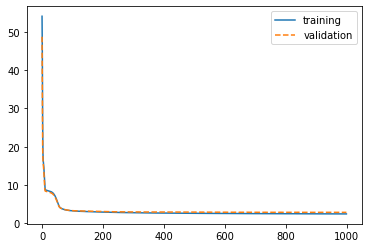

In [42]:
train_loss = nett.history[:, 'train_loss']
valid_loss = nett.history[:, 'valid_loss']

plt.plot(train_loss, '-', label='training')
plt.plot(valid_loss, '--', label='validation')
# plt.ylim(2,5)
# plt.xlim(0,500)
plt.legend()
plt.show()

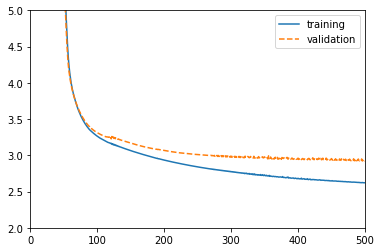

In [43]:
train_loss = nett.history[:, 'train_loss']
valid_loss = nett.history[:, 'valid_loss']

plt.plot(train_loss, '-', label='training')
plt.plot(valid_loss, '--', label='validation')
plt.ylim(2,5)
plt.xlim(0,500)
plt.legend()
plt.show()

In [30]:
prova = nett.predict(Xval)

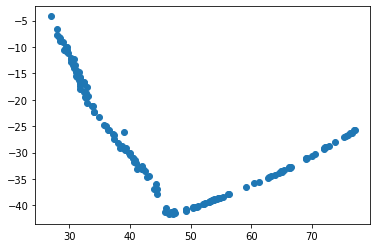

In [31]:
x1 = prova[:,0]
y1 = prova[:,1]
plt.scatter(x1, y1)

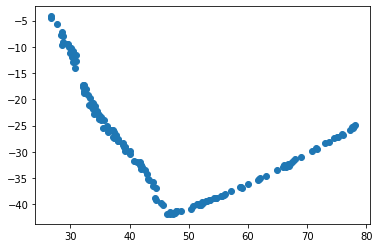

In [32]:
x_real = yval[:,0]
y_real = yval[:,1]
plt.scatter(x_real, y_real)

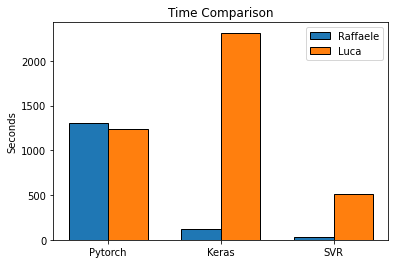

In [56]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = ['Pytorch' , 'Keras', 'SVR']
raffaele_tempo = [1303.044, 120, 30]
luca_tempo = [1234, 2314, 512]
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, raffaele_tempo, width, edgecolor='black', label='Raffaele')
rects2 = ax.bar(x + width/2, luca_tempo, width, edgecolor='black', label='Luca')

ax.set_ylabel('Seconds')
ax.set_title('Time Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()